# Information Retrieval Project (Phase 1)

## import libraries

In [1]:
import os
import json
import pickle
import re
import math
import numpy as np
import matplotlib.pyplot as plt
from string import punctuation
from sklearn.linear_model import LinearRegression
from parsivar import Normalizer, Tokenizer, FindStems

### Structure of dataset
- dataset 
    - docID
        - title
        - content
        - tags
        - date
        - url
        - category

## Load Dataset

In [2]:
docs_path = './IR_data_news_12k.json'

def load_docs(docs_path):
    result = {}
    with open(docs_path) as f:
        docs = json.load(f)
        for docID, body in docs.items():
            result[docID] = {}
            result[docID]['title'] = body['title']
            result[docID]['content'] = body['content']
            result[docID]['url'] = body['url']
    return result

docs = load_docs(docs_path)

## Preprocess Data

### Remove Punctuation
<div dir="rtl">
    حذف علائم نگارشی موجود در زبان برای جلوگیری از ورود آنها به دیکشنری
</div>

In [3]:
tmp_sentence = 'به گزارش ایسنا سمینار شیمی آلی از امروز ۱۱ شهریور ۱۳۹۶ در دانشگاه علم و صنعت ایران آغاز به کار کرد. این سمینار تا ۱۳ شهریور ادامه می یابد.'

pure_sentence = re.sub(f'[{punctuation}؟،٪×÷»«]+', '', tmp_sentence)
print(pure_sentence)

به گزارش ایسنا سمینار شیمی آلی از امروز ۱۱ شهریور ۱۳۹۶ در دانشگاه علم و صنعت ایران آغاز به کار کرد این سمینار تا ۱۳ شهریور ادامه می یابد


### Normalize Text
<div dir="rtl">
    هم فرم و هم شکل کردن قسمت های مختلف تکست برای ایجاد توانایی مقایسه میان تکست های مختلف و قالب های متفاوت
    <br>
    برای مثال انگلیسی کردن تمامی اعداد
</div>

In [4]:
normalizer = Normalizer()
normalized_sentence = normalizer.normalize(pure_sentence)
print(normalized_sentence)

به گزارش ایسنا سمینار شیمی آلی از امروز 11 شهریور 1396 در دانشگاه علم و صنعت ایران آغاز به کار کرد این سمینار تا 13 شهریور ادامه می‌یابد


### Tokenize Text
<div dir="rtl">
    تبدیل متن به توکن ها
</div>

In [5]:
tokenizer = Tokenizer()
tokens = tokenizer.tokenize_words(normalized_sentence)
print(tokens)

['به', 'گزارش', 'ایسنا', 'سمینار', 'شیمی', 'آلی', 'از', 'امروز', '11', 'شهریور', '1396', 'در', 'دانشگاه', 'علم', 'و', 'صنعت', 'ایران', 'آغاز', 'به', 'کار', 'کرد', 'این', 'سمینار', 'تا', '13', 'شهریور', 'ادامه', 'می\u200cیابد']


### Word Stemming
<div dir="rtl">
    ریشه یابی کلمات موجود در متن. این کار باعث می شود که با تغییر شکل یک کلمه آن کلمه مجزا در نظر گرفته نشده و بتوان به شکل بهتری میزان تکرار آن کلمه در متن را به دست آورد.
</div>

In [6]:
stemmer = FindStems()
stemmed_tokens = list(map(stemmer.convert_to_stem, tokens))
print(stemmed_tokens)

['به', 'گزارش', 'ایسنا', 'سمینار', 'شیمی', 'آلی', 'از', 'امروز', '11', 'شهریور', '1396', 'در', 'دانشگاه', 'علم', 'و', 'صنعت', 'ایران', 'آغاز', 'به', 'کار', 'کرد', 'این', 'سمینار', 'تا', '13', 'شهریور', 'ادامه', 'یافت&یاب']


### Remove Stopwords
<div dir="rtl">
    حذف کلمات با تکرار زیاد. این کلمات با تکرار زیاد باعث جاگیری اضافه در دیکشنری و ایندکس شده و از آنجایی که در غالب سند ها نیز وجود دارند، در فرایند بازیابی سند کمک چندانی نمی کنند.
</div>

In [7]:
persian_stopwords_path = './persian-stopwords.txt'

def load_stopwords(stopwords_path):
    stopwords_set = None
    with open(stopwords_path, 'r') as f:
        stopwords_set = set(f.read().split('\n'))
    return stopwords_set

In [8]:
stopwords_set = load_stopwords(persian_stopwords_path)
stopwords_set

{'آخرین',
 'آقای',
 'آمد',
 'آمده',
 'آمده_است',
 'آن',
 'آنان',
 'آنجا',
 'آنها',
 'آنچه',
 'آنکه',
 'آورد',
 'آوری',
 'آیا',
 'ابتدا',
 'اثر',
 'اجرا',
 'اخیر',
 'از',
 'است',
 'اش',
 'اغلب',
 'افراد',
 'افرادی',
 'افزود',
 'البته',
 'اما',
 'امر',
 'امکان',
 'اند',
 'او',
 'اول',
 'اولین',
 'اکنون',
 'اگر',
 'ایشان',
 'این',
 'اینجا',
 'اینکه',
 'با',
 'بار',
 'باره',
 'باز',
 'باشد',
 'باشند',
 'باعث',
 'بالا',
 'باید',
 'بخش',
 'بخشی',
 'بدون',
 'بر',
 'برابر',
 'براساس',
 'برای',
 'برخی',
 'برداری',
 'بروز',
 'بزرگ',
 'بسیار',
 'بسیاری',
 'بعد',
 'بعضی',
 'بلکه',
 'بنابراین',
 'بندی',
 'به',
 'بهتر',
 'بهترین',
 'بود',
 'بودن',
 'بودند',
 'بوده',
 'بوده_است',
 'بی',
 'بیان',
 'بیرون',
 'بیش',
 'بیشتر',
 'بیشتری',
 'بین',
 'تا',
 'تاکنون',
 'تبدیل',
 'تحت',
 'ترتیب',
 'تعداد',
 'تعیین',
 'تغییر',
 'تمام',
 'تمامی',
 'تنها',
 'تهیه',
 'تو',
 'جا',
 'جاری',
 'جای',
 'جایی',
 'جدی',
 'جدید',
 'جریان',
 'جز',
 'جمع',
 'جمعی',
 'حال',
 'حالا',
 'حالی',
 'حتی',
 'حد',
 'حداقل',
 'حدود',

In [9]:
def remove_stopwords(words, persian_stopwords_path='./persian-stopwords.txt'):
    persian_stopwords = load_stopwords(persian_stopwords_path)
    return [word for word in words if word not in persian_stopwords]

In [10]:
stemmed_tokens_without_stopwords = remove_stopwords(stemmed_tokens)

In [11]:
print(f'total words with stopwords: {len(stemmed_tokens)}')
print(f'total words without stopwords: {len(remove_stopwords(stemmed_tokens_without_stopwords))}')

total words with stopwords: 28
total words without stopwords: 20


### Stacking These components to make a Pipeline

In [65]:
def preprocess(text, stopwords_remove=True, stemming=True):
    normalizer = Normalizer()
    tokenizer = Tokenizer()
    stemmer = FindStems()
    
    pure_text = re.sub(f'[{punctuation}؟،٪×÷»«]+', '', text)
    normal_text = normalizer.normalize(pure_text)
    res = tokenizer.tokenize_words(normal_text)
    if stemming:
        res = list(map(stemmer.convert_to_stem, res))
    if stopwords_remove:
        res = remove_stopwords(res, persian_stopwords_path)
    
    return res

print(preprocess('سلام من امروز می خواهم این تابع را ۳ بار امتحان کنم.'))

['سلام', 'امروز', 'خواست&خواه', 'تابع', '3', 'امتحان', 'کرد&کن']


In [66]:
def preprocess_contents(docs_dict, stopwords_remove=True, stemming=True):
    normalizer = Normalizer()
    tokenizer = Tokenizer()
    stemmer = FindStems()
    
    for docID, body in docs_dict.items():
        body['content'] = preprocess(body['content'], stopwords_remove, stemming)
        
    return docs_dict

preprocessed_docs = preprocess_contents(load_docs(docs_path))

## Indexing

### Dictionary (Vocabulary)
At first, we must create a dictionary of all words that have been seen in the docs.

In [16]:
def create_dictionary(docs):
    dictionary = set()
    for body in docs.values():
        dictionary.update(body['content'])
    return dictionary

dictionary = create_dictionary(preprocessed_docs)

### Positional Index
Structure of Index:
- Token
    - Total Appearance
    - docs
        - list of docs
            - total incidences in every doc
            - list of each position in every doc

In [31]:
def create_index(docs):
    dictionary = set()
    index = {}
    for docID, body in docs.items():
        if int(docID) % 1000 == 0:
            print(f'{int(docID)} have been processed.')
        content = body['content']
        for token_i in range(len(content)):
            token = content[token_i]
            if token not in dictionary:
                dictionary.add(token)
                index[token] = {
                    'total_app': 1,
                    'docs': [
                        {
                            docID:{
                                'total_inc': 1,
                                'position': [token_i,]
                            }
                        }
                    ]
                }
            else:
                index[token]['total_app'] += 1
                
                docs_ID = list(map(lambda x : list(x.keys())[0], index[token]['docs']))
                docs_ID_set = set(map(lambda x : list(x.keys())[0], index[token]['docs']))
                if docID not in docs_ID_set:
                    index[token]['docs'].append({
                        docID:{
                            'total_inc': 1,
                            'position': [token_i,]
                        }
                    })
                else:
                    doc_index = docs_ID.index(docID)
                    index[token]['docs'][doc_index][docID]['total_inc'] += 1
                    index[token]['docs'][doc_index][docID]['position'].append(token_i)
    return index, dictionary

index, dictionary = create_index(preprocessed_docs)

0 have been processed.
1000 have been processed.
2000 have been processed.
3000 have been processed.
4000 have been processed.
5000 have been processed.
6000 have been processed.
7000 have been processed.
8000 have been processed.
9000 have been processed.
10000 have been processed.
11000 have been processed.
12000 have been processed.


In [2]:
def save_index(index, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(index, outp, pickle.HIGHEST_PROTOCOL)
        print(f'index saved in {filename}')
    
def load_index(filename):
    index = None
    with open(filename, 'rb') as inp:
        index = pickle.load(inp)
    return index

In [3]:
index = load_index('index_v2.pkl')
dictionary = load_index('dictionary_v2.pkl')

In [4]:
index['معاوضه']

{'total_app': 34,
 'docs': [{'2267': {'total_inc': 1, 'position': [338]}},
  {'2511': {'total_inc': 1, 'position': [23]}},
  {'2897': {'total_inc': 1, 'position': [131]}},
  {'2980': {'total_inc': 1, 'position': [28]}},
  {'3059': {'total_inc': 2, 'position': [105, 144]}},
  {'3084': {'total_inc': 1, 'position': [45]}},
  {'3131': {'total_inc': 1, 'position': [31]}},
  {'3140': {'total_inc': 1, 'position': [53]}},
  {'3241': {'total_inc': 1, 'position': [62]}},
  {'3323': {'total_inc': 1, 'position': [60]}},
  {'3334': {'total_inc': 1, 'position': [43]}},
  {'3451': {'total_inc': 2, 'position': [43, 54]}},
  {'3495': {'total_inc': 1, 'position': [281]}},
  {'3567': {'total_inc': 1, 'position': [25]}},
  {'3687': {'total_inc': 2, 'position': [25, 49]}},
  {'3950': {'total_inc': 2, 'position': [175, 191]}},
  {'4447': {'total_inc': 3, 'position': [196, 329, 346]}},
  {'4939': {'total_inc': 2, 'position': [62, 112]}},
  {'4945': {'total_inc': 2, 'position': [5, 81]}},
  {'4951': {'total_i

## Query Processing

In [87]:
def process_query(query):
    
    intersect = set()
    
    query_index = dict()
    exception_index = dict()
    phrase_index = dict()
    
    token_docID = dict()
    exception_token_docID = dict()
    phrase_token_docID = dict()
    
    exception_tokens = list()
    phrasal_tokens = list()
    
    # find tokens immediately after exclamation's mark
    exception_tokens = re.findall(r'\!\s(\w+)', query)
    # find tokens in between double quotation
    phrasal_tokens = re.findall(r'"([^"]*)"', query)
    # remove two types of tokens extracted before from main query
    raw_tokens = re.sub(r'\!\s\w+', '', query)
    raw_tokens = re.sub(r'"[^"]*"', '', raw_tokens)
            
#     print(raw_tokens)
#     print(" ".join(exception_tokens))
#     print(" ".join(phrasal_tokens))
    
    # preprocess each type of token in query
    if len(raw_tokens):
        preprocessed_query = preprocess(raw_tokens)
        preprocessed_query = [token for token in preprocessed_query if token in dictionary]
        raw_tokens = preprocessed_query
    if len(exception_tokens) > 0:
        preprocessed_exception = preprocess(" ".join(exception_tokens))
        preprocessed_exception = [token for token in preprocessed_exception if token in dictionary]
        exception_tokens = preprocessed_exception
    if len(phrasal_tokens):
        preprocessed_phrasals = list()
        for phrase in phrasal_tokens:
            preprocessed_phrasals.append(preprocess(phrase))
    
    # separate docID related to extracted raw tokens
    if len(raw_tokens):
        for token in preprocessed_query:
            query_index[token] = index[token]
            token_docID[token] = set(map(lambda x: int(list(x.keys())[0]), index[token]['docs']))

    # separate docID related to extracted negated tokens
    if len(exception_tokens) > 0:
        for token in preprocessed_exception:
            exception_index = index[token]
            exception_token_docID[token] = set(map(lambda x: int(list(x.keys())[0]), index[token]['docs']))
            
    if len(phrasal_tokens):
        for phrase in preprocessed_phrasals:
            phrase_token_docID[tuple(phrase)] = dict()
            for token in phrase:
                phrase_index = index[token]
                phrase_token_docID[tuple(phrase)][token] = set(map(lambda x: int(list(x.keys())[0]), phrase_index['docs']))
         
#         print(phrase_token_docID)
        phrase_docID = dict()
        for phrase in preprocessed_phrasals:
            phrase_docID[tuple(phrase)] = set()
            phrase_intersect = phrase_token_docID[tuple(phrase)][phrase[0]]
            for token in phrase:
                phrase_intersect = phrase_intersect.intersection(phrase_token_docID[tuple(phrase)][token])
            
            for docID in list(phrase_intersect):
#                 print(index[phrase[0]]['docs'])
                sequential_position = None
                for i in range(len(phrase)):
                    current_token = phrase[i]
                    for doc in index[current_token]['docs']:
                        if int(list(doc.keys())[0]) == docID:
                            current_position = set(doc[f'{docID}']['position'])
                            if i == 0:
                                sequential_position = current_position
                                continue
                            current_position = set(map(lambda x : x - i, current_position))
                            sequential_position = sequential_position.intersection(current_position)
                            
                if len(sequential_position) > 0:
                    phrase_docID[tuple(phrase)].add(docID)
                    
        final_phrase_docID = phrase_docID[tuple(preprocessed_phrasals[0])]
        for phrase in preprocessed_phrasals:
            final_phrase_docID = final_phrase_docID.intersection(phrase_docID[tuple(phrase)])
                
    if len(raw_tokens) > 0:
        intersect = token_docID[preprocessed_query[0]]
        for token in preprocessed_query:
            intersect = intersect.intersection(token_docID[token])
        
    if len(phrasal_tokens) > 0:
        if len(intersect) > 0:
            intersect = intersect.intersection(final_phrase_docID)
        else: 
            intersect = final_phrase_docID
        
    if len(exception_tokens) > 0:
        for token in  preprocessed_exception:
            intersect = intersect - exception_token_docID[token]
            
#     print(f'intersect: {intersect}')
        
    related_docID = list(intersect)
#     print(related_docID)
#     print(query_index)
    related_docs = list()
    for docID in related_docID:
        total_token_inc = 0
        if len(raw_tokens) > 0:
            for token in preprocessed_query:
                for doc in query_index[token]['docs']:
                    if int(list(doc.keys())[0]) == docID:
                        total_token_inc += doc[f'{docID}']['total_inc']
        if len(phrasal_tokens) > 0:
            for phrase in preprocessed_phrasals:
                for token in phrase:
                    for doc in index[token]['docs']:
                        if int(list(doc.keys())[0]) == docID:
                            total_token_inc += doc[f'{docID}']['total_inc']
        related_docs.append((docID, total_token_inc))
        
    related_docs.sort(key=lambda x : x[1], reverse=True)
        
    return related_docs[:5]

In [79]:
def print_query_result(query, with_content=False):
    res = process_query(query)
    for doc, rank in res:
        print(20*'*')
        print(f'Rank: {rank}')
        print(f'docID: {doc}')
        print(f'Title: {docs[f"{doc}"]["title"]}')
        print(f'URL: {docs[f"{doc}"]["url"]}')
        if with_content:
            print(f'{docs[f"{doc}"]["content"]}')
        print(20*'*')

# Sample Queries

## Query 1
<div dir="rtl">
    تحریم‌های آمریکا علیه ایران
</div>

In [88]:
print_query_result('تحریم‌های آمریکا علیه ایران')

********************
Rank: 169
docID: 9742
Title: مرکز پژوهش‌های مجلس: مذاکرات وین به توافقی زودهنگام منجر نمی‌شود
URL: https://www.farsnews.ir/news/14000924000773/مرکز-پژوهش‌های-مجلس-مذاکرات-وین-به-توافقی-زودهنگام-منجر-نمی‌شود
********************
********************
Rank: 149
docID: 6929
Title: توضیحات یک منبع آگاه درباره وقفه مذاکرات وین
URL: https://www.farsnews.ir/news/14001222000450/توضیحات-یک-منبع-آگاه-درباره-وقفه-مذاکرات-وین
********************
********************
Rank: 107
docID: 11864
Title: اهرم‌سازی از افغانستان در برجام/ نقطه عزیمت آمریکا در مذاکرات جامع با ایران چیست؟
URL: https://www.farsnews.ir/news/14000803000676/اهرم‌سازی-از-افغانستان-در-برجام-نقطه-عزیمت-آمریکا-در-مذاکرات-جامع-با
********************
********************
Rank: 95
docID: 9496
Title: گفت‌وگوی مشروح | ترقی: آمریکا شروط ایران را نپذیرد، پشت در مذاکرات می‌ماند/ روحانی کشور را به بن‌بست کشاند
URL: https://www.farsnews.ir/news/14000926000385/گفت‌وگوی-مشروح-|-ترقی-آمریکا-شروط-ایران-را-نپذیرد-پشت-در-مذاکرات

docID = 9742
<div dir="rtl">
    با گذشت نزدیک به یک سال از روی‌کار آمدن دولت بایدن، 
    <u>آمریکا</u>
    به برجام بازنگشته و از رفع مؤثر تحریم‌‌ها خودداری می‌‌ورزد. ایده اصلی دولت بایدن این بود که با اعمال «فشار هوشمند» یا همان «ترکیب دیپلماسی و چندجانبه‌گرایی با کمپین فشار حداکثری» 
    <u>ایران</u>
    را وادار به پذیرش «توافق قوی‌تر و طولانی‌تر» کند.  به همین دلیل، دولت بایدن بیش از آنکه به‌دنبال بازگشت فوری به برجام باشد در پی طراحی سازوکاری بود که چگونه می‌‌توان توافق هسته‌ای را به بستری برای دستیابی به تبدیل توافقی جامع برای مهار ایران کرد. تیم مذاکره‌کننده آمریکا با چنین هدفی در فروردین‌ماه 1400 وارد مذاکرات وین شد و پیش‌نویسی را برای گفتگو درباره دو موضوع اصلی مذاکره یعنی «تحریم» و « برنامه هسته‌‌ای» ارائه کرد که طبق آن از یکسو آمریکا با حفظ بخش مهمی از 
    <u>تحریم‌‌ها</u>
    به‌دنبال استمرار اهرم فشار 
    <u>علیه</u>
    ایران و ازسوی دیگر به بهانه «آستانه گریز یک‌ساله» خواستار محدودیت‌‌های فنی و نظارتی فرابرجامی ازجمله تخریب سانتریفیوژهای نسل جدید و زنجیره ساخت این ماشین‌‌ها بود.
</div>

docID = 6929
<div dir="rtl">
    * <u>تحریم‌های آمریکا علیه ایران</u>

آمریکا پس از تسخیر لانه‌ جاسوسی آمریکا در تهران، «کارتر» در تاریخ 8 نوامبر 1979م. با استناد به قانون‌ «کنترل صدور تسلیحات نظامی»، کشتی حامل‌ لوازم یدکی نظامی متعلق به ایران را توقیف کرد. ارزش این لوازم 300 میلیون دلار بود. با اوج‌گیری کشمکش‌های سیاسی بر سر مسئله‌ تصرف سفارت، دولت موقت، اعلام کرد تمام دارایی‌های‌ خود را از بانک‌های آمریکا خارج خواهد کرد. کارتر با لحاظ این احتمال، در کشور شرایط اضطراری اعلام کرد و با استناد به قانون شرایط اضطراری اقتصاد بین‌الملل (IEEPA) و قانون‌ شرایط اضطراری ملی (NEA)، با صدور دستور ویژه‌ی شماره‌ی (12170)، تمام دارایی‌های ایران در آمریکا را به تصرف خود درآورد.
</div>

docID = 11864
<div dir="rtl">
    FATF مشکل ما را حل نمی‌کرد بلکه مشکلات را بر ما رسوب می داد چون ما متاثر از 
    <u>تحریم‌های</u>
    اولیه و ثانویه آمریکایی‌ها هستیم که نه به برجام ربطی دارد و نه بهFATF و هیچ سازمان بین المللی. یک تصمیم ملی داخلی ایالات متحده 
    <u>آمریکا</u>
    برای 
    <u>ایران</u>
    است تا تحریم‌ها را موثر بکنند.
    <br>
    ظهره وند: در آذربایجان هم این فضا را به وجود می آورند. ایران کشوری مادر است و عمق استراتژیک آن در محیط پیرامونی خودش و وسیع‌تر از جغرافیای طبیعی اش هست و امروز مردم منطقه متوجه ظرفیت ها و موقعیت ایران و هم‌راستایی در تهدید و فرصت با ایران هستند. این هم‌راستایی به یک تهدید معتبر 
    <u>علیه</u>
    غرب تبدیل شده و آمریکایی ها اگر نتوانند ایران و چین را در افغانستان متوقف کنند دیگر نمی توانند در محیط داخلی خودشان هم منسجم شوند.
</div>

docID = 9496
<div dir="rtl">
    اکنون در مذاکرات وین، 4+1 به عنوان یک تیم بدعهد و بدهکار  جلوه می‌کند و 
    <u>ایران</u>
    به عنوان کشوری که کاملاً به تمام تعهدات خود عمل کرده و طلبکار است و ابتکار عمل را در دست دارد، در مذاکرات دست بالاتر را به نمایش گذاشته است. به نظر می‌رسد اینها در وضعیت مذاکرات تأثیر قابل توجهی دارد و وقایعی که طی مدت خروج 
    <u>آمریکا</u>
    از برجام رخ داده، برای مردم جهان قابل نادیده گرفتن نیست. طرف مذاکره کننده نمی‌تواند ترور سردار سلیمانی، شهید فخری‌زاده (با جایگاهی که شهید فخری‌زاده در انرژی هسته‌ای و مخالفت با برجام داشت) 4 حمله دشمنان به تأسیسات هسته ای ایران و زوایای متعدد به سایت ها و سانترفیوژها، تشدید 
    <u>تحریم‌ها</u>
    و ادامه تحریم‌ها توسط آمریکا و غرب را نادیده بگیرد. اینها وقایعی است که در طول این مدت رخ داده و این رخدادهای طبیعی، وضعیتی را پدیدآورده که تیم مذاکره کننده غربی با موضع منفعلانه برخورد کند.
</div>

docID = 10757
<div dir="rtl">
    علی رغم اینکه هیچ علامت مثبتی از دولت بایدن مبنی بر پذیرش شروط 
    <u>ایران</u>
    دیده نمی‌شد، دولت حسن روحانی دور جدیدی از مذاکرات هسته‌ای را با اروپایی‌ها موسوم به مذاکرات وین آغاز کرد. مذاکراتی که با هدف احیای برجام صورت گرفت و بنا بود زمینه بازگشت 
    <u>آمریکا</u>
    را به برجام فراهم کند. با این حال بدون اینکه این مذاکرات به نتیجه‌ای برسد، دولت روحانی به پایان رسید.

دولت سیّد ابراهیم رئیسی که روی کار آمد اعلام کرد میز مذاکره را ترک نخواهد کرد، با این وجود، زمین بازی را از «مذاکره برای احیای برجام» به «مذاکره برای رفع تحریم» تغییر داد و به موضعی بازگشت که قبلاً به‌عنوان سیاست قطعی نظام اعلام شده بود؛ یعنی رفع همه تحریم‌ها و راستی‌آزمایی از سوی ایران.

در راستای همین سیاست است که علی باقری معاون سیاسی وزیر امور خارجه که این روزها در حال  فراهم کردن مقدمات مذاکرات ۸ آذر با اروپایی‌هاست، اعلام می‌کند که زین پس مذاکره هسته‌ای نداریم و آنچه به جریان خواهد افتاد، مذاکره برای رفع 
    <u>تحریم‌های</u>
    ظالمانه 
    <u>علیه</u>
    ایران است. سیاستی که توپ را در زمین طرف غربی مذاکرات قرار می‌دهد. چرا که ایران پس از امضای برجام، دغدغه یا بهانه غربی‌ها مبنی بر صلح‌آمیز بودن برنامه هسته‌ای این کشور را برطرف کرده بود و آژانس بین‌المللی انرژی اتمی نیز با راستی‌آزمایی انجام تعهدات ایران در ۱۵ مرحله بر صحت انجام آن، مهر تأیید زده بود. این اهرمی بود در دست ایران تا با اتکا به آن، طرف مقابل را وادار به رفع تحریم‌ها کند یا حداقل بهانه را از دست آن‌ها خارج کند.
</div>

## Query 2
<div dir="rtl">
تحریم‌های آمریکا ! ایران
</div>

In [89]:
print_query_result('تحریم‌های آمریکا ! ایران')

********************
Rank: 14
docID: 7615
Title: یک مأموریت‌ فتنه 88 کاهش قدرت چانه‌زنی مسؤولان در مذاکرات بود
URL: https://www.farsnews.ir/news/14001129000373/یک-مأموریت‌-فتنه-کاهش-قدرت-چانه‌زنی-مسؤولان-در-مذاکرات-بود
********************
********************
Rank: 13
docID: 7261
Title: سود مافیای اسلحه‌سازی آمریکا در ناامن بودن جهان است
URL: https://www.farsnews.ir/news/14001211000898/سود-مافیای-اسلحه‌سازی-آمریکا-در-ناامن-بودن-جهان-است
********************
********************
Rank: 10
docID: 8282
Title: خطیب جمعه تهران: سازمان‌ همکاری اسلامی در برابر کشتار مردم یمن سکوت کرده است
URL: https://www.farsnews.ir/news/14001108000202/خطیب-جمعه-تهران-سازمان‌-همکاری-اسلامی-در-برابر-کشتار-مردم-یمن-سکوت
********************
********************
Rank: 9
docID: 7491
Title: مسائل اقتصادی کشور را معطل نتیجه مذاکرات نمی‌‌کنیم
URL: https://www.farsnews.ir/news/14001203000383/مسائل-اقتصادی-کشور-را-معطل-نتیجه-مذاکرات-نمی‌‌کنیم
********************
********************
Rank: 7
docID: 9994
Title: امام ج

docID = 7615
<div dir="rtl">
    حجت‌الاسلام مجتبی ذوالنور نماینده مردم قم در مجلس، در گفت‌وگو با خبرنگار پارلمانی خبرگزاری فارس، با اشاره به مسأله 
    <u>تحریم‌های</u>
    ضدایرانی در حوزه‌های مختلف و ریشه‌های اصلی وقوع پدیده تحریم اظهار داشت: فلسفه وضع تحریم‌ها، افزایش فشار بر مردم و نظام بوده است تا تاب‌آوری مردم از بین برود و مقاومت آنها بشکند و در نهایت تسلیم شوند.
    <br>
    نماینده مردم قم در مجلس شورای اسلامی، با اشاره به تاثیر فتنه 88 بر گسترش فشارهای تحریمی تصریح کرد: یکی از مأموریت‌های فتنه 88، کاهش قدرت چانه‌زنی مسؤولان در پای میز مذاکره بود و حتی اطلاعاتی در دست داریم که برخی آقازاده‌ها در آن سال به 
    <u>آمریکا</u>
    رفت و آمد می‌کردند و به غربی‌ها و آمریکایی‌ها پیغام می‌دادند که ما نفس نظام را در داخل گرفته‌ایم و اگر شما هم فشارهای تحریمی را افزایش دهید، کار نظام تمام است.
</div>

docID = 7261
<div dir="rtl">
    وی افزود: 
    <u>آمریکا</u>
    با سوءاستفاده از شرایط به وجود آمده بین روسیه و اوکراین، کشورهای اروپای شرقی را از روسیه می ترساند تا برای حفاظت از خودشان در برابر حمله احتمالی روسیه، به آمریکا و مافیای حاکم بر آن باج دهند.  
    <br>
نماینده ادوار مجلس ضمن تاکید به هماهنگ بودن کشورهای غربی گفت: کشورهای غربی به صورت گروهی عمل می کنند و در بزنگاه ها کاملا هماهنگ هستند همچنان که شاهد هستیم در جریان نبرد میان روسیه و اوکراین در اوج اتحاد 
    <u>تحریم هایی</u>
    را به روسیه تحمیل کردند.
</div>

docID = 8282
<div dir="rtl">
    وی به مذاکرات لغو 
    <u>تحریم‌ها</u>
    هم اشاره کرد و گفت: آمریکا در پی غارتگری است، نه مذاکره؛ 
    <u>آمریکا</u>
    خواب و خیال غارتگری قبل از انقلاب را دارد و این خواب هرگز تعبیر نشده و نخواهد شد.
</div>

docID = 7491
<div dir="rtl">
    وی افزود: ما باید بدانیم که 
    <u>آمریکا</u>
    به عنوان یک دشمن همواره در صدد ضربه زدن به کشور، نظام و ملت ماست و طبیعتا بنایش برای آزادسازی 
    <u>تحریم‌ها</u>
    و ایجاد گشایش اقتصادی در کشور ما نخواهد بود.
</div>

docID = 9994
<div dir="rtl">
    وی در ادامه با بیان اینکه 
    <u>آمریکا</u>
    در دوره‌های مختلف و در زمان ترامپ و قبل از او در سه جبهه علیه نظام جمهوری اسلامی توطئه کرد، افزود: این سه جبهه شامل وزارت خزانه‌داری آمریکا که مرتب 
        <u>تحریم‌های</u>
        به قول خودشان فلج‌کننده را آماده می‌کند، وزارت خارجه آمریکا که با مسافرت‌های مختلف دولت‌ها و شرکت‌ها را از معامله با ما مرعوب می‌کنند و نیز سازمان سیا است که از ابتدای انقلاب تاکنون در صدد ایجاد نارضایتی در کشور بوده است.
</div>

# Query 3
<div dir="rtl">
    کنگره ضدتروریست
</div>

In [90]:
print_query_result('کنگره ضدتروریست')

********************
Rank: 5
docID: 6929
Title: توضیحات یک منبع آگاه درباره وقفه مذاکرات وین
URL: https://www.farsnews.ir/news/14001222000450/توضیحات-یک-منبع-آگاه-درباره-وقفه-مذاکرات-وین
********************


<div dir="rtl">
    ریگان که نمی‌خواست کمتر از 
    <u>کنگره ضدتروریست</u>
    جلوه کند، 3هفته بعد با صدور دستور ویژه‌ی (12613) ورود هرگونه کالا و خدمات از ایران را ممنوع کرد. وی برای صدور این دستور به بند 505 «قانون همکاری‌های‌ بین‌المللی امنیتی و توسعه»، مصوب سال‌ 1985م. استناد کرد. در واقع زمانی که ایران درگیر جنگ تحمیلی بود، ایالات متحده به تعریف سیاست‌های تحریمی پرداخت که بتواند بر نتیجه‌ی جنگ ایران و عراق تأثیری شگرف بگذارد و رقیب نوپای اسلامی خود را در جنگی نابرابر از میدان به در کند. اما پایان جنگ، تافته‌ی بافته‌ی آمریکا را ریش ریش کرد.
</div>

## Query 4
<div dir="rtl">
    "تحریم هسته‌ای" آمریکا ! ایران
</div>

In [91]:
print_query_result('"تحریم هسته‌ای" آمریکا ! ایران')

there is no output for this query

## Query 5
<div dir="rtl">
    اورشلیم ! صهیونیست
</div>

In [92]:
print_query_result('اورشلیم ! صهیونیست')

there is no output for this query

# Zipf Law
در این قسمت، می خواهیم رابطه بین تکرار توکن ها در کل اسناد و رتبه توکن بپردازیم
$$\log cf_i = \log K - \log i$$

In [17]:
def token_incidence(docs):
    token_inc = dict()
    for body in docs.values():
        for token in body['content']:
            if token_inc.get(token):
                token_inc[token] += 1
            else: 
                token_inc[token] = 1
    
    return [(token, inc) for token, inc in token_inc.items()]

In [18]:
dictionary_with_stopwords = token_incidence(preprocess_contents(load_docs(docs_path), stopwords_remove=False))
dictionary_without_stopwords = token_incidence(preprocess_contents(load_docs(docs_path), stopwords_remove=True))

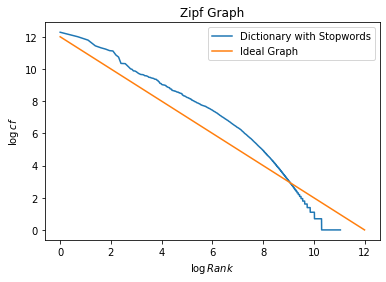

In [19]:
def draw_zipf_plot(dictionary, plot_label):
    dictionary.sort(key=lambda x: x[1], reverse=True)
    incid = list(map(lambda x: math.log(x[1]), dictionary))
    interval = range(1, len(dictionary)+1)
    interval = list(map(math.log, interval))
#     print(incid)
    plt.title('Zipf Graph')
    plt.xlabel(r'$\log Rank$')
    plt.ylabel(r'$\log cf$')
    plt.plot(interval, incid, label=plot_label)
    plt.plot(range(13), range(13)[::-1], label='Ideal Graph')
    plt.legend()
draw_zipf_plot(dictionary_with_stopwords, plot_label='Dictionary with Stopwords')

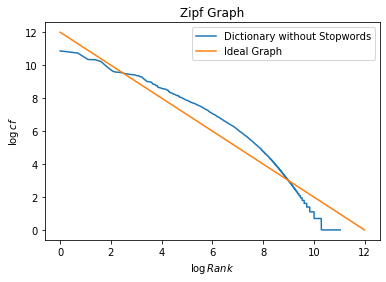

In [20]:
draw_zipf_plot(dictionary_without_stopwords, plot_label='Dictionary without Stopwords')

<div dir="rtl">
    همانطور که مشاهده می شود، با افزایش جایگاه کلمات در دیکشنری تقریبا با شیب -۱ تعداد تکرار کلمه در کل داک ها کاهش پیدا می کند. چرا که در این نمودار داده ها بعد از اعمال لگاریتم محاسبه شده اند. پس قانون zipf در اینجا برقرار می باشد.
    <br>
    با توجه به نمودار می توان بیان کرد که با حذف stopwords خاصیت zipf به صورت بارزتری رخ داده و از آن پیروی می کند. به خصوص به ازای کلمات پرتکرار.
</div>

# Heaps Law
در این قسمت می خواهیم به ارتباط میان تعداد توکن های استخراج شده و سایز دیکشنری بپردازیم.
$$\log M = \log K + b\log T$$

In [68]:
def token_heaps(docs):
    seen_docs = 0
    seen_token_num = 0
    dictionary = set()
    dictionary_size = []
    dictionary_size_estimation = []
    seen_token_num_list = []
    for body in docs.values():
        for token in body['content']:
            seen_token_num += 1
            dictionary.add(token)
            dictionary_size.append(len(dictionary))
        seen_docs += 1
        if seen_docs in [500, 1000, 1500, 2000]:
            dictionary_size_estimation.append(len(dictionary))
            seen_token_num_list.append(seen_token_num)
    
    return dictionary_size, dictionary_size_estimation, seen_token_num_list

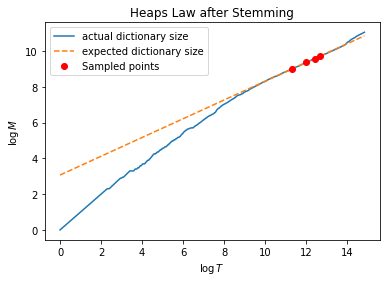

In [77]:
def draw_heaps_plot(docs, title):
    dictionary_size, dictionary_size_estimation, seen_token_num_list = token_heaps(docs)
    model = LinearRegression()
    X = np.array(list(map(math.log, seen_token_num_list))).reshape(-1, 1)
    y = np.array(list(map(math.log, dictionary_size_estimation)))
    model.fit(X, y)
    plt.title(title)
    plt.xlabel(r'$\log T$')
    plt.ylabel(r'$\log M$')
    plt.plot(list(map(math.log, range(1, len(dictionary_size)+1))), list(map(math.log, dictionary_size)), label='actual dictionary size')
    estimation_list = list(map(math.log, [1] + seen_token_num_list + [len(dictionary_size)]))
    plt.plot(estimation_list, list(map(lambda x: model.coef_ * x + model.intercept_, estimation_list)), linestyle='--', label='expected dictionary size')
    plt.plot(list(map(math.log, seen_token_num_list)), list(map(math.log, dictionary_size_estimation)), 'ro', label='Sampled points')
    plt.legend()
    
draw_heaps_plot(preprocessed_docs, 'Heaps Law after Stemming')

In [67]:
preprocessed_docs_without_stemming = preprocess_contents(docs, stemming=False)

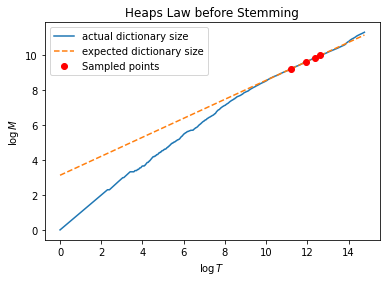

In [78]:
draw_heaps_plot(preprocessed_docs_without_stemming, 'Heaps Law before Stemming')

<div dir="rtl">
    در این قسمت نیز مشاهده می شود که با توجه به نقاطی که در آن نمونه برداری صورت گرفته است، سایز تخمینی دیکشنری نزدیک به سایز واقعی آن می باشد. بنابراین در اینجا نیز می توان بیان کرد که قانون heaps در هر دو حالت بعد از ریشه یابی و قبل از آن برقرار می باشد.
    
    در این حالت به دلیل اینکه برخی از کلمات که پیش از این پس از استخراج یک مدخل جدید در مجموعه دیکشنری ایجاد میکردند، حال به عنوان یک مدخل که در گذشته اضافه شده است، اضافه می شود و به همین دلیل در این حالت شیب خط کمتر است.
</div>

# Challenges with Stemming

<div dir="rtl">
    مشکل در تشخیص جمع کلمات با «ات»
</div>

In [98]:
preprocess('مکرر')

['مکرر']

In [97]:
preprocess('مکررات')

['مکررا']

<div dir="rtl">
    تفاوت قائل شدن میان دو کلمه با ریشه یکسان
</div>

In [126]:
preprocess('آزمایشی')

['آزمایشی']

In [127]:
preprocess('آزمایش')

['آزمایش']

<div dir="rtl">
    تلاش برای ریشه یابی کردن بر روی کلمات خارجی
</div>

In [147]:
preprocess('آنتی هیستامین')

['آنت', 'هیستامین']